In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from vugrad.ops import Normalize
from vugrad.core import TensorNode, Op
from copy import deepcopy
from scipy.stats import ttest_ind

class Normalize1(Op):
    @staticmethod
    def forward(context, x):
        sumd = x.sum(axis=1, keepdims=True)
        context['x'], context['sumd'] = x, sumd
        return x / sumd

    @staticmethod
    def backward(context, go):
        x, sumd = context['x'], context['sumd']
        return (go / sumd) - (x/(sumd * sumd) * go.sum(axis=1, keepdims=True))

In [2]:
x = np.random.uniform(high=100, size=(4, 5))
dx = np.random.randn(4, 5)
context = dict()

In [3]:
Normalize.forward(context, x)
Normalize.backward(context, dx)

array([[ 2.75449307e-04,  1.44657079e-04, -8.08022947e-03,
         6.29451352e-03,  7.38753390e-03],
       [ 3.09229354e-03,  7.37854450e-05,  5.43856218e-05,
        -3.44856103e-03,  1.79156519e-03],
       [ 7.78690506e-04, -8.19852177e-04,  1.39652084e-04,
         8.47123411e-04, -1.11677932e-03],
       [ 5.49865294e-03,  1.05996651e-03,  3.69905943e-04,
        -1.84670709e-03, -1.15371501e-03]])

In [4]:
Normalize1.backward(context, dx)

array([[-3.14082894e-03, -1.47328350e-03, -6.61347983e-03,
         2.72941660e-03,  8.49817566e-03],
       [ 1.77496497e-03, -3.38070511e-04, -6.88530512e-04,
        -3.34093881e-03,  2.59257486e-03],
       [ 7.51166799e-04, -9.98284741e-04,  3.74025547e-05,
         9.98196675e-04, -7.88481289e-04],
       [ 4.96447926e-03,  1.82885085e-04, -5.32917813e-04,
        -2.89190518e-03, -1.72254135e-03]])

In [5]:
EPOCH = 4000

def GD(norm):
    b = TensorNode(np.asarray([[0], [-0.5], [0.3], [0.7], [-0.5]]))
    x = TensorNode(np.random.uniform(high=100, size=(4, 5)))

    values = list()
    for i in range(EPOCH):
        o = norm.do_forward(x)
        o = o.matmul(b)
        ot = TensorNode(deepcopy(o.value.T))
        o = ot.matmul(o)
        o.backward()
        x.value = x.value - 30 * x.grad
        o.zero_grad()
        values.append(o.value.squeeze())
    return values

def runs(norm, n=100):
    return pd.DataFrame([GD(norm) for _ in range(n)]).T

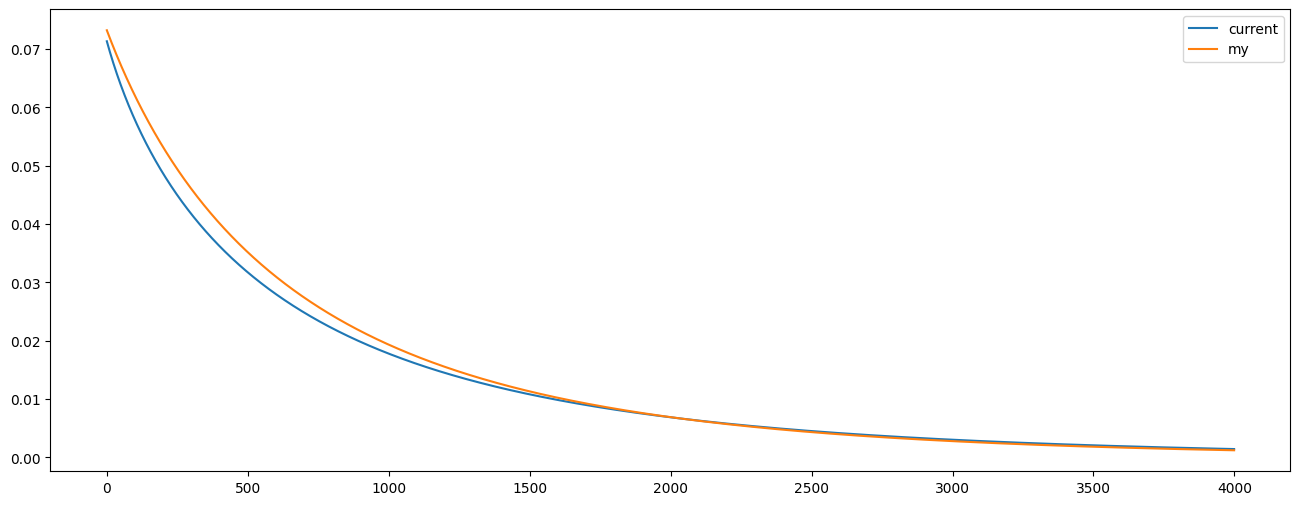

In [6]:
df1, df2 = runs(Normalize, n=500), runs(Normalize1, n=500)

plt.figure(figsize=(16, 6))
plt.plot(df1.mean(axis=1), label='current')
plt.plot(df2.mean(axis=1), label='my')
plt.legend()
plt.show()

In [21]:
df1.iloc[-1].mean()

0.0014353256738679123

In [22]:
df2.iloc[-1].mean()

0.0012245646423265305

In [20]:
ttest_ind(df1.iloc[-1].astype(np.float32), df2.iloc[-1].astype(np.float32))

Ttest_indResult(statistic=2.8331537829447995, pvalue=0.004701948638510984)